# Sales Analysis with Pandas

This project is inspired by the work of Keith Galli, available on his GitHub repository: Pandas Data Science Tasks (https://github.com/KeithGalli/Pandas-Data-Science-Tasks). Keith presents a series of intriguing questions related to a dataset, providing an excellent opportunity to practice our skills in data manipulation and analysis using Python's Pandas and Matplotlib libraries.

## Key Challenges

Throughout this project, we will tackle the following challenges:

- Best Month for Sales and Earnings: We will determine the best-performing month in terms of sales and calculate the total earnings for that specific month.
- Top-Selling City: Identifying the city that generated the highest sales volume in terms of ordered quantity.
- Optimal Advertisement Timing: Investigating the optimal time for displaying advertisements to maximize the likelihood of customer purchases.
- Frequently Purchased Products: Discovering which products are often purchased together.
- Best-Selling Product: Identifying the product that achieved the highest sales, and offering insights into the factors contributing to its success.

To address these questions, we will leverage the power of Python's Pandas and Matplotlib libraries. 

## Project Approach

Rather than simply following the tutorial, this project encourages active engagement and problem-solving. I will independently work through each question, utilizing Pandas for data manipulation and analysis and Matplotlib for data visualization. My goal is not only to answer these questions but also to understand the underlying techniques and concepts involved in the process.

By the end of this project, I aim to have a deeper understanding of data science techniques and gain more confidence in using Pandas and Matplotlib for real-world data analysis tasks.

Let's embark on this data-driven journey, exploring the dataset and uncovering valuable insights along the way!

## Preparations

### Imports
First of all we will do all necessary imports for the project. With the OS library (Miscellaneous operating system interfaces) we have a module that provides us with a portable way of using operating system dependent functionalities. With the panads library, we can do fast, powerful, flexible and easy data analysis and manipulation. We will need the numpy library for some calculations to create x- & y-grids to plot a 2D Kernel Estimate for better understanding of the data. For plotting reasons we will use the matplotlib library. We will also need the gaussian_kde library for our Plot based on the 2D Kernel Estimates. Furthermore, we need for question four the functions combinations and counter to identify products that have been ordered together. Finally, to check for significant correlations we will use the pearsonr function from the scipy.stats library.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde
from itertools import combinations
from collections import Counter
from scipy.stats import pearsonr

### Read and Merge Sales Data of the whole Year
First of all we have to read in the sales data. The sales data is contained in multiple CSV files within a fodler in the working diretory. In the following we will read all the csv files, concatenate them and write the output to another CSV file.

In [2]:
# Name of folder where data is in
path = "./Sales_Data"

# save name of csv files in list
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

# Create Dataframe, read csv files and save them into a dataframe
dfs = []

for csv in csv_files:
    current_data = pd.read_csv(path+"/"+csv)
    dfs.append(current_data)

combined_df = pd.concat(dfs)

# Next, we save the dataframe in a new csv file, without the index column:
combined_df.to_csv("./Output/Sales_Data_2019", index=False)

In [3]:
#combined_df.to_csv("Sales_Data_2019.csv", index=False)
df = pd.read_csv("./Output/Sales_Data_2019.csv")

###  Observe, Clean, and Prepare Data

First we will observe the data, its structure, and its current statistics. This will help us to get a basic understanding of how the data looks like and if there might be some issues with the data.

In [4]:
# Check first couple rows to get an idea of the format of each column
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


In [5]:
df.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


Accidently, we concatenated not just the data but also the headlines of each table. Thus, we will remove the rows that contain the entry "Order ID" 

In [6]:
df = df.drop(df[df['Order ID'] == "Order ID"].index)
df.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,185950,185950,185950,185950,185950,185950
unique,178437,19,9,23,142395,140787
top,160873,USB-C Charging Cable,1,11.95,12/15/19 20:16,"193 Forest St, San Francisco, CA 94016"
freq,5,21903,168552,21903,8,9


#### Handling Unknown Values
Now let us have a closer look at the Na's, where they occur and how we should treat these unknown values. Let us therefore first see how many NAs we have in our Dataframe. Next we will check how many NAs we have in each Column.

In [7]:
# Check how many unknown values exist within the whole dataframe
df.isna().sum().sum()

3270

There are plenty of unknown values within our DataFrame. Let us have a closer look in which columne these values actually accure

In [8]:
col_names = []
# iterating the columns
for col in df.columns:
    col_names += [col]

#Count nas across the columns
nas_list = []
i=0
# iterating the columns
for col in df.columns:
    nas = df[col_names[i]].isna().sum()
    nas_list.append(nas)
    i += 1
    
na_count = pd.DataFrame([nas_list],["Number of Nas"])
na_count.columns = [col_names]
na_count

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
Number of Nas,545,545,545,545,545,545


We have plenty of NAs in the Dataframe. Each column has the same amount of NAs. This might indicate that we have full rows of NAs. After checking the csv files, it appears to be that all NAs are always in the same row. Thus, we can just remove all rows that contain NA values, without the fear of losing data.

In [9]:
df = df.dropna(axis=0, how="all")
# Check once more how many unknown values exist within the whole dataframe
df.isna().sum().sum()

0

### Create New Columns for Day, Month, Year and Time
As we want analyze the data based on different levels of time, we will add more columns, which contain information about the day, month and year of the order. We will additionaly parse the columns for day, month, and year into integers as it makes sense to handle this values as numeric.

In [10]:
df['Order Date'] = pd.to_datetime(df['Order Date'],format="%m/%d/%y %H:%M")
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Year'] = df['Order Date'].dt.year
df['Time'] = df['Order Date'].dt.time
df['Hour'] = df['Order Date'].dt.hour
df['Minute'] = df['Order Date'].dt.minute

### Create Street, City, State, and ZIP Column

In [11]:
df[["Street","City","State"]] = df['Purchase Address'].str.split(',', expand=True)
df['ZIP'] = df['State'].str[3:]
df['State'] = df['State'].str[1:3]
df['City'] = df['City']+" ("+df['State']+")"

### Create a Sales Column
In addition, we want to know more about the Sales numbers. Therefore, we will calculate the sales of each order by multiplyng the quantity with the price for each item. As the values wihtin these columns are non numerical values, we have to parse from string to float values.

In [12]:
# Parse to numeric values for Quantity & Price 
df["Quantity Ordered"] = df["Quantity Ordered"].astype('float')
df["Price Each"] = df["Price Each"].astype('float')
df['Sales'] = df["Quantity Ordered"]*df["Price Each"]

In [13]:
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Day,Year,Time,Hour,Minute,Street,City,State,ZIP,Sales
0,176558,USB-C Charging Cable,2.0,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,19,2019,08:46:00,8,46,917 1st St,Dallas (TX),TX,75001,23.90
2,176559,Bose SoundSport Headphones,1.0,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,7,2019,22:30:00,22,30,682 Chestnut St,Boston (MA),MA,02215,99.99
3,176560,Google Phone,1.0,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019,14:38:00,14,38,669 Spruce St,Los Angeles (CA),CA,90001,600.00
4,176560,Wired Headphones,1.0,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,12,2019,14:38:00,14,38,669 Spruce St,Los Angeles (CA),CA,90001,11.99
5,176561,Wired Headphones,1.0,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,30,2019,09:27:00,9,27,333 8th St,Los Angeles (CA),CA,90001,11.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186845,259353,AAA Batteries (4-pack),3.0,2.99,2019-09-17 20:56:00,"840 Highland St, Los Angeles, CA 90001",9,17,2019,20:56:00,20,56,840 Highland St,Los Angeles (CA),CA,90001,8.97
186846,259354,iPhone,1.0,700.00,2019-09-01 16:00:00,"216 Dogwood St, San Francisco, CA 94016",9,1,2019,16:00:00,16,0,216 Dogwood St,San Francisco (CA),CA,94016,700.00
186847,259355,iPhone,1.0,700.00,2019-09-23 07:39:00,"220 12th St, San Francisco, CA 94016",9,23,2019,07:39:00,7,39,220 12th St,San Francisco (CA),CA,94016,700.00
186848,259356,34in Ultrawide Monitor,1.0,379.99,2019-09-19 17:30:00,"511 Forest St, San Francisco, CA 94016",9,19,2019,17:30:00,17,30,511 Forest St,San Francisco (CA),CA,94016,379.99


## Solving the Challenges
### Question 1: What was the best month for sales? How much was earned that month?

This question is straightforward and easy to solve with a couple of lines of code. We solely have to sum up each months sales. To better see how the sales have been distributed across the year, we can vizualize each months sales within one bar chart.

Let us have a look at the dataframe after adding new columns and manipulating the dataframe.

In [14]:
# Calculate the sum of all Sales based on Months
Monthly_Sales = df.groupby(['Month'])['Sales'].sum()
# Parse data again into a DataFrame
Monthly_Sales = pd.DataFrame(Monthly_Sales)
# Print Monthly Sales by ordered in descending order by Best Selling Months 
print(Monthly_Sales.sort_values(by="Sales",ascending=False))
# Create month column fpr vizualizing purposes
Monthly_Sales['Month'] = Monthly_Sales.index

            Sales
Month            
12     4613443.34
10     3736726.88
4      3390670.24
11     3199603.20
5      3152606.75
3      2807100.38
7      2647775.76
6      2577802.26
8      2244467.88
2      2202022.42
9      2097560.13
1      1822256.73


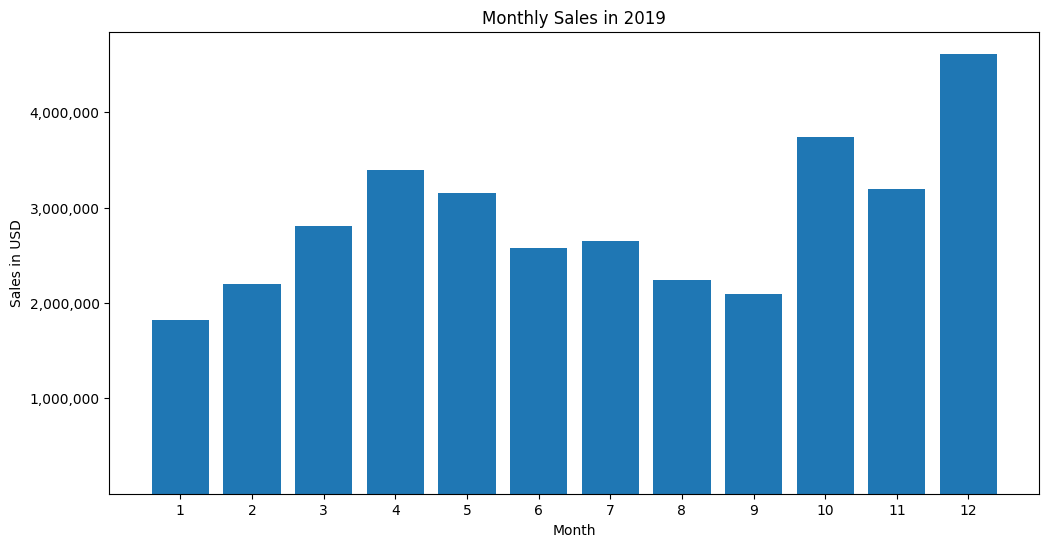

In [15]:
import matplotlib.pyplot as plt

# Create a figure
fig= plt.subplots(figsize=(12, 6))

# Create a bar plot for monthly sales
plt.bar(Monthly_Sales["Month"], Monthly_Sales["Sales"])

# Set plot title, labels, and x-axis ticks
plt.title("Monthly Sales in 2019")
plt.xlabel("Month")
plt.xticks(Monthly_Sales["Month"])  # Use the "Month" values for x-axis ticks

# Set y-axis label and customize y-axis tick values
plt.ylabel("Sales in USD")
y_tick_values = [1000000, 2000000, 3000000, 4000000]
plt.yticks(y_tick_values)

# Format y-axis tick labels with commas for better readability
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

# Display the plot
plt.show()


Answer to Question 1: We can clearly see that december is the month with the highest sales. This might be due to the christmas holidays where people buy presents for their loved ones. Furthermore, people might get bonuses towards the end of the year and have more money available than troughtout the year.

### Question 2: What city sold the most product?

This question is a bit more tricky as we there might be multiple cities with the same name. Therefore, we have to check the State of each city to make sure we do not misinterpret the data. In the following we will summarize the ordered quantity of each city from the whole year. We are taking into account that cities can have the same name (e.g. Portland), but different states.

In [16]:
# Calculate the sum of all Sales based on Months
City_Quantities = df.groupby(['City'])['Quantity Ordered'].sum()
City_Quantities = pd.DataFrame(City_Quantities)
# Print City_Quantities by ordered in descending order by most sold products
print(City_Quantities.sort_values(by="Quantity Ordered",ascending=False))
City_Quantities['City'] = City_Quantities.index

                     Quantity Ordered
City                                 
 San Francisco (CA)           50239.0
 Los Angeles (CA)             33289.0
 New York City (NY)           27932.0
 Boston (MA)                  22528.0
 Dallas (TX)                  16730.0
 Atlanta (GA)                 16602.0
 Seattle (WA)                 16553.0
 Portland (OR)                11303.0
 Austin (TX)                  11153.0
 Portland (ME)                 2750.0


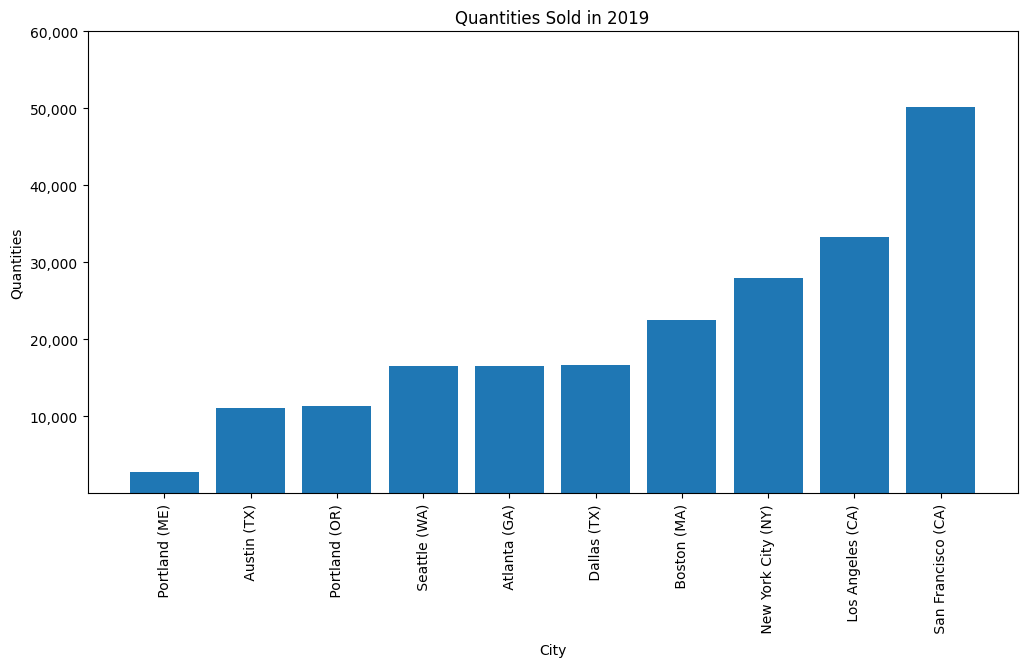

In [17]:
# Create a figure
fig= plt.subplots(figsize=(12, 6))

# Sort the data by "Quantity Ordered" in ascending order
City_Quantities = City_Quantities.sort_values(by="Quantity Ordered", ascending=True)

# Create a bar plot
plt.bar(City_Quantities["City"], City_Quantities["Quantity Ordered"])

# Set plot title, labels, and customize tick rotation
plt.title("Quantities Sold in 2019")
plt.xlabel("City")
plt.xticks(City_Quantities["City"], rotation='vertical')
plt.ylabel("Quantities")

# Customize y-axis tick values and formatting
plt.yticks([10000, 20000, 30000, 40000, 50000, 60000])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

# Display the plot
plt.show()

### Question 3: What time should we display advertisemens to maximize the likelihood of customer’s buying product?

This question is not very intuitive, as it is very difficult to measure the influence of and displayed advertisment and how this advertisment affects the likelihood of customer's buying a product. Furthermore, we do not have usage data of the website, on which the buyer is placing it's order and the advertisment channels where the customer receives the ads from. But what we have is the time when each order was placed. This gives us an indication when the buyers might be most likely to buy the product. Thus, we will have a look at the number of orders across each hour throughout the day. Therefore, we have to count the orders based on the hour of the day.

In [18]:
# Calculate the amount of Orders per occured time entry on hour level
Orders_by_H = pd.DataFrame()
Orders_by_H["Number of Orders"] = df.groupby(["Hour"])['Order ID'].count()
Orders_by_H=Orders_by_H.reset_index()
Orders_by_H

,Hour,Number of Orders
0,0,3910
1,1,2350
2,2,1243
3,3,831
4,4,854
5,5,1321
6,6,2482
7,7,4011
8,8,6256
9,9,8748


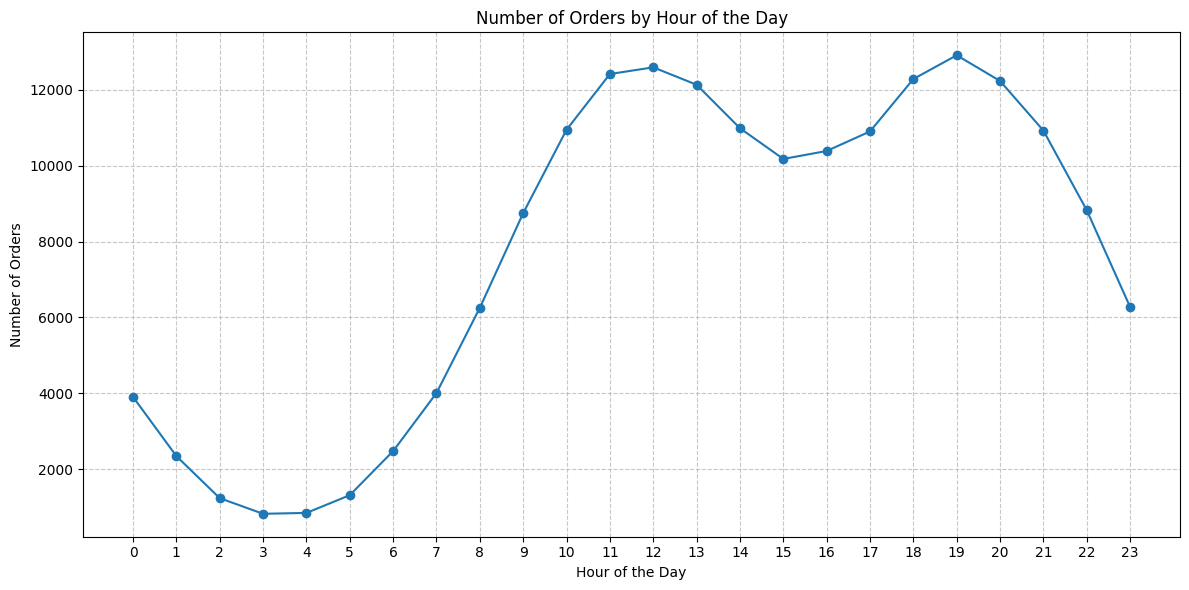

In [19]:
# Let's create a line plot

# Set the figure size (width, height)
plt.figure(figsize=(12, 6))  
# Create the line plot
plt.plot(Orders_by_H['Hour'], Orders_by_H['Number of Orders'], marker='o', linestyle='-')  
# Labels for x & y axis + Title of the plot + setting tick lockation + adding grid lines to the plot
plt.xlabel('Hour of the Day') 
plt.ylabel('Number of Orders') 
plt.title('Number of Orders by Hour of the Day') 
plt.xticks(Orders_by_H['Hour']) 
plt.grid(True, linestyle='--', alpha=0.7) 

plt.tight_layout()  # Ensure labels and title fit within the figure
plt.show()  # Display the plot

Based on this first analysis we can already see, that the customers place more orders during certain times throughout the day. Thus, we could conclude, that we should place advertisment during or even before the peak times of the placed number of orders. The drawback here is that we just see the numbers of orders per hour. Thus, orders placed close to 11.00 am are still counted towards 10 am. As advertisments are very expensive, it might make sense to have a more detailed temporal view. In the next two plots we will have a look at the number of ordes on a minute level. We will also look at the 2D-Kernel Density Plot to get a better understanding of the distributions of time and orders throughout the day.

In [20]:
# Calculate the amount of Orders per occured time entry on minute level
Orders_by_Time = pd.DataFrame()
Orders_by_Time["Number of Orders"] = df.groupby(['Time'])['Order ID'].count()
Orders_by_Time=Orders_by_Time.reset_index()
Orders_by_Time

,Time,Number of Orders
0,00:00:00,82
1,00:01:00,65
2,00:02:00,71
3,00:03:00,89
4,00:04:00,84
...,...,...
1435,23:55:00,97
1436,23:56:00,73
1437,23:57:00,88
1438,23:58:00,89


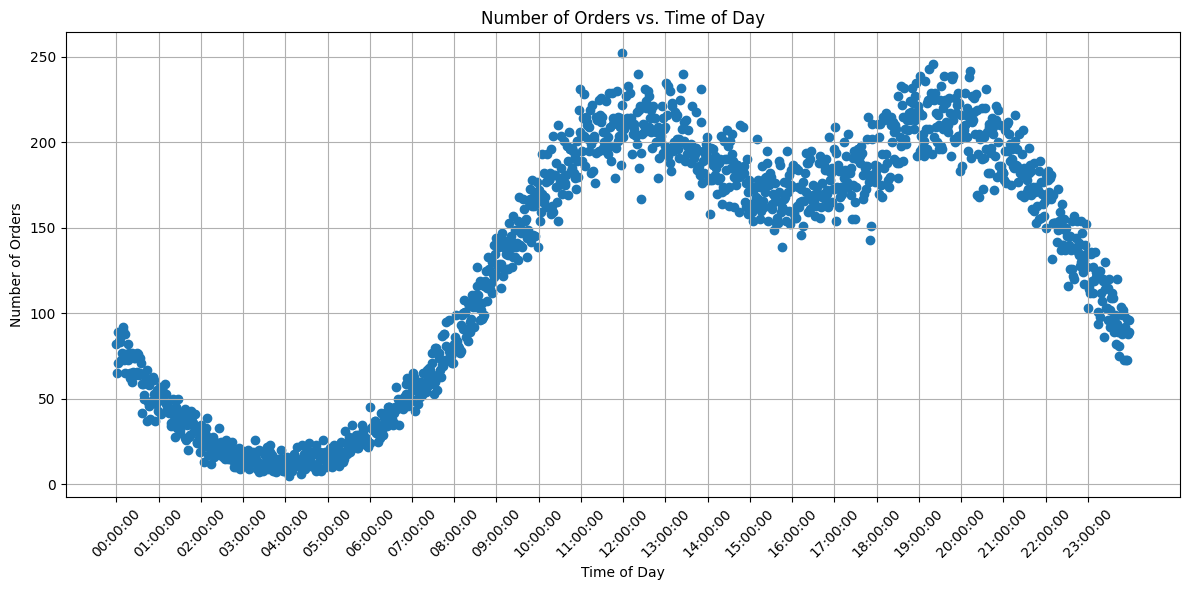

In [21]:
# Convert 'Time' column to string
Orders_by_Time['Time'] = Orders_by_Time['Time'].apply(lambda x: x.strftime('%H:%M:%S'))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.scatter(Orders_by_Time['Time'], Orders_by_Time['Number of Orders'], marker='o', linestyle='-')

# Customize the plot
ax.set_xlabel('Time of Day')
ax.set_ylabel('Number of Orders')
ax.set_title('Number of Orders vs. Time of Day')
ax.grid(True)

# Set custom x-axis ticks for every 2 hours
x_ticks = Orders_by_Time['Time'][::60]  # Assuming data is recorded every minute (60 minutes x 2)
plt.xticks(x_ticks, rotation=45)

# Show the plot
plt.tight_layout()  # Ensures labels and titles fit within the figure
plt.show()


Answer Question 3: The previous plot gives us already great insights regarding the times in which the orders are coming in. This plot represents a scatter plot that shows how many orders appeared each minute throughout a day (based on data of the whole year). We can see, that the peak times for incoming orders are between 11.00-13.00 o'clock and between 19.00-21.00 o'clock. Thus, we can try to improve the likelihood for customers to buy products by advertising our products during these peak order times. Obviously, there are a variety of different products, so further analysis is necessary to identify the product that we actually should advertise during which times. But for now, this analysis is sufficient to answer question 3. 

In the next section there is a 2D-Kernel Density Plot for minutes and the number of orders. This plot was just for plotting practice puposes and didn't help further in answering the question.

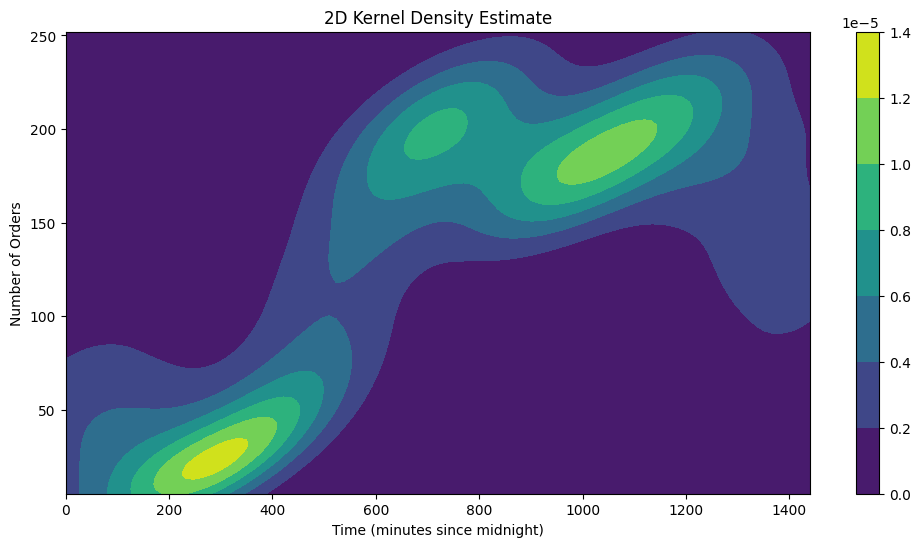

In [22]:
# Convert 'Time' column to datetime
Orders_by_Time['Time'] = pd.to_datetime(Orders_by_Time['Time'], format='%H:%M:%S')

# Extract minutes from datetime
Orders_by_Time['Time (minutes)'] = Orders_by_Time['Time'].dt.hour * 60 + Orders_by_Time['Time'].dt.minute

# Create a 2D kernel density estimate
x = Orders_by_Time['Time (minutes)']
y = Orders_by_Time['Number of Orders']
xy = np.vstack([x, y])
k = gaussian_kde(xy)

# Define the grid for the plot
x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])
z = k(grid_points)

# Create a figure and axis with a larger size
fig, ax = plt.subplots(figsize=(12, 6))
contour = ax.contourf(x_grid, y_grid, z.reshape(x_grid.shape), cmap='viridis')

# Customize the plot (add labels and a title)
plt.xlabel('Time (minutes since midnight)')
plt.ylabel('Number of Orders')
plt.title('2D Kernel Density Estimate')

# Create a colorbar manually
cbar = plt.colorbar(contour)

# Show the plot
plt.show()

### Question 4: What products are most often sold together?

This question is a very challenging one. To reduce calculation time along the way, we will just look at the Order IDs that are mentioned at least twice in the dataframe. Afterwards, we need to group the products that occur in the same orders. Next we need extra help from the library itertools as we need to get all product combinations for each order. Therefore, we will use the combinations function from the itertool library to get all the combination for the products within each order. As a result we have a new column called "Product Combinations". This column contains all different product combinations. It is important to mention that the combinations function won't count in both orders of products.

In [23]:
# Let us first remove all non duplicates to save calculation power along the way
relevant_columns = df[df['Order ID'].duplicated(keep=False)]

# Create a new DataFrame with relevant columns
relevant_columns = relevant_columns[['Order ID', 'Product']]

# Sort Orders and columns
relevant_columns = relevant_columns.sort_values(['Order ID','Product'])

# Group data by order ID and create lists of products in each order
orders_grouped = relevant_columns.groupby('Order ID')['Product'].apply(list).reset_index()

# Create a function to find product combinations
def find_product_combinations(products_list):
    product_combinations = list(combinations(products_list, 2))
    return product_combinations

# Apply the function to each row to find product combinations
orders_grouped['Product Combinations'] = orders_grouped['Product'].apply(find_product_combinations)

# Flatten the combinations
product_combinations_flat = [item for sublist in orders_grouped['Product Combinations'] for item in sublist]

# Count the occurrences of each product combination
product_combination_counts = Counter(product_combinations_flat)

# Find the most frequently sold product combinations
most_common_combinations = product_combination_counts.most_common(15)

# Save it as dataframe and print results
most_common_combinations_df = pd.DataFrame(most_common_combinations)
most_common_combinations_df = most_common_combinations_df.rename(columns={0: "Product Combination", 1: "Count"})
most_common_combinations_df['Product Combination'] = most_common_combinations_df['Product Combination'].apply(lambda x: ' & '.join(map(str, x)))
most_common_combinations_df

,Product Combination,Count
0,Lightning Charging Cable & iPhone,1015
1,Google Phone & USB-C Charging Cable,999
2,Wired Headphones & iPhone,462
3,Google Phone & Wired Headphones,423
4,Apple Airpods Headphones & iPhone,373
5,USB-C Charging Cable & Vareebadd Phone,368
6,Bose SoundSport Headphones & Google Phone,228
7,USB-C Charging Cable & Wired Headphones,205
8,Vareebadd Phone & Wired Headphones,149
9,Lightning Charging Cable & Wired Headphones,129


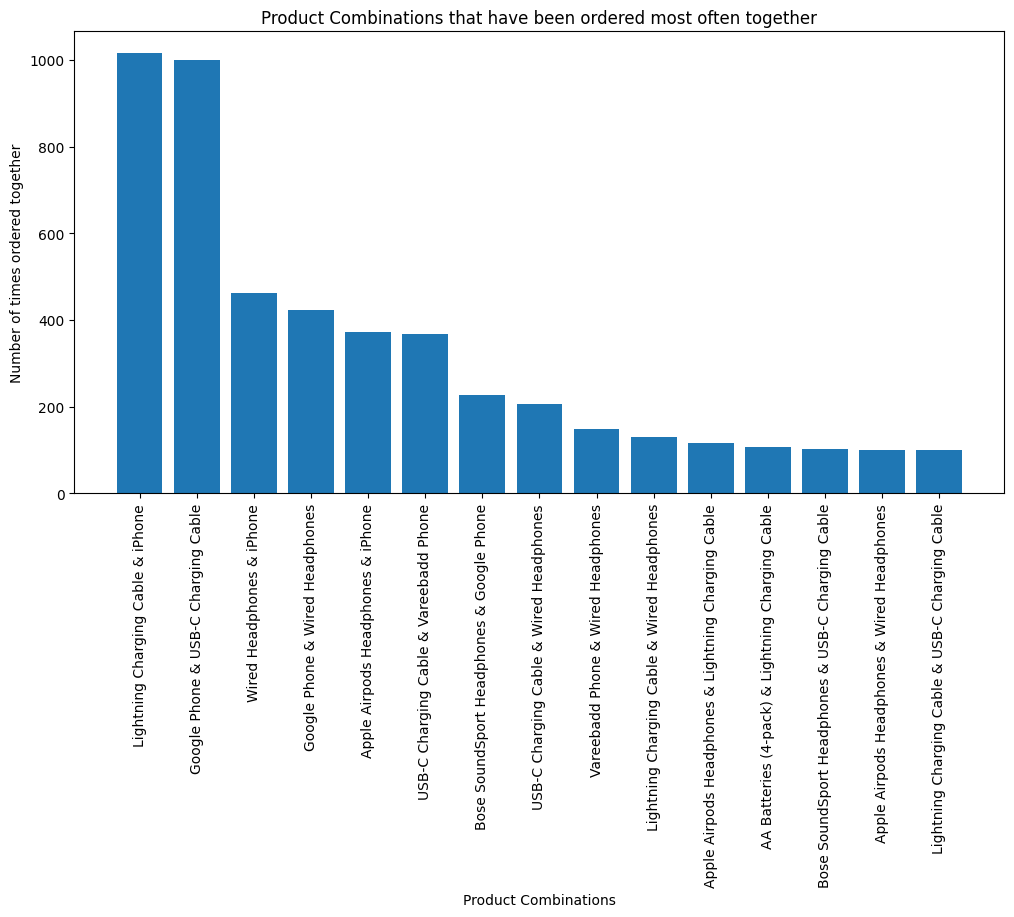

In [24]:
# Create a figure 
fig= plt.subplots(figsize=(12, 6))

# Create a bar plot
plt.bar(most_common_combinations_df["Product Combination"], most_common_combinations_df["Count"])

# Set plot title, labels, and customize tick rotation
plt.title("Product Combinations that have been ordered most often together")
plt.xlabel("Product Combinations")
plt.xticks(most_common_combinations_df["Product Combination"], rotation='vertical')
plt.ylabel("Number of times ordered together")

# Display the plot
plt.show()

#### Answer Question 4: 
Ultimately, we can say that the **Lightning Charging Cable and the Iphone** have been sold most often together, closely followed by the combination of the **Google Phone and the USB-C Charging Cable**. Knowing what products are most often sold together can provide several benefits for our company, both in terms of improving customer experience and increasing revenue. By identifying pairs or groups of products that are frequently bought together, a seller can create **targeted cross-selling strategies**. For example, if customers often buy a phone and a charging cable together, we can bundle these items or offer discounts when purchased together, increasing the average order value. In addtion, we can use this information to make **personalized product recommendations to customers**. When a customer adds one item to their cart, we can suggest other frequently co-purchased items, enhancing the shopping experience and potentially leading to more sales. These are just some of the benefits of knowing the product combinations of ordered products.

### Additonal Analysis of Product combination of three Products

In this section we will do the same analysis for combinations with three products.

In [25]:
# Group data by order ID and create lists of products in each order
orders_grouped = relevant_columns.groupby('Order ID')['Product'].apply(list).reset_index()

# Create a function to find product combinations
def find_product_combinations(products_list):
    product_combinations = list(combinations(products_list, 3))
    return product_combinations

# Apply the function to each row to find product combinations
orders_grouped['Product Combinations'] = orders_grouped['Product'].apply(find_product_combinations)

# Flatten the combinations
product_combinations_flat = [item for sublist in orders_grouped['Product Combinations'] for item in sublist]

# Count the occurrences of each product combination
product_combination_counts = Counter(product_combinations_flat)

# Find the most frequently sold product combinations
most_common_combinations = product_combination_counts.most_common(15)

# Save it as dataframe and print results
most_common_combinations_df = pd.DataFrame(most_common_combinations)
most_common_combinations_df = most_common_combinations_df.rename(columns={0: "Product Combination", 1: "Count"})
most_common_combinations_df['Product Combination'] = most_common_combinations_df['Product Combination'].apply(lambda x: ' & '.join(map(str, x)))
most_common_combinations_df

,Product Combination,Count
0,Google Phone & USB-C Charging Cable & Wired He...,89
1,Lightning Charging Cable & Wired Headphones & ...,63
2,Apple Airpods Headphones & Lightning Charging ...,47
3,Bose SoundSport Headphones & Google Phone & US...,35
4,USB-C Charging Cable & Vareebadd Phone & Wired...,33
5,Apple Airpods Headphones & Wired Headphones & ...,27
6,Bose SoundSport Headphones & Google Phone & Wi...,24
7,Bose SoundSport Headphones & USB-C Charging Ca...,16
8,Bose SoundSport Headphones & Vareebadd Phone &...,5
9,Bose SoundSport Headphones & USB-C Charging Ca...,5


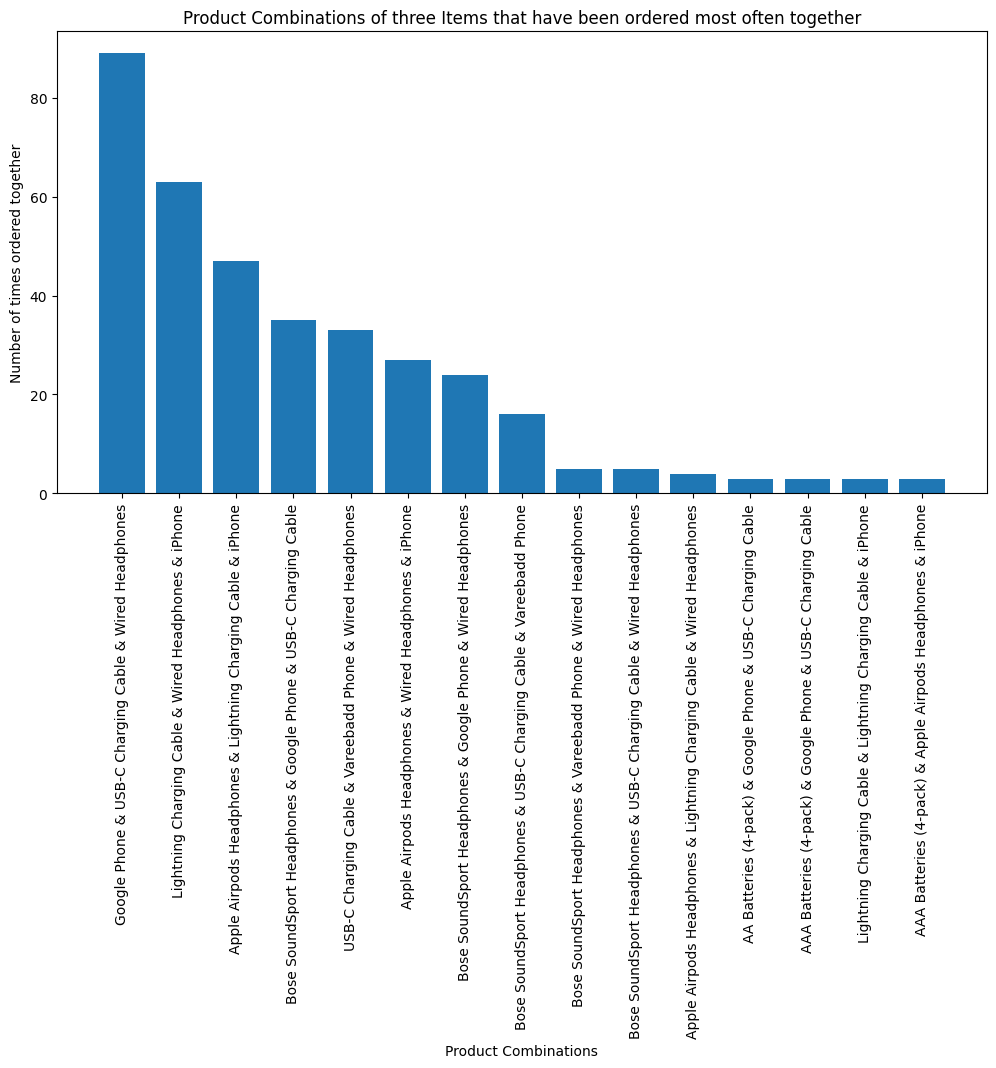

In [26]:
# Create a figure 
fig= plt.subplots(figsize=(12, 6))

# Create a bar plot
plt.bar(most_common_combinations_df["Product Combination"], most_common_combinations_df["Count"])

# Set plot title, labels, and customize tick rotation
plt.title("Product Combinations of three Items that have been ordered most often together")
plt.xlabel("Product Combinations")
plt.xticks(most_common_combinations_df["Product Combination"], rotation='vertical')
plt.ylabel("Number of times ordered together")

# Display the plot
plt.show()

Ultimately, we can say that the **Google Phone, the USB-C Charging Cable and Wired Headphones** have been sold most often together, closely followed by the combination of the **Lightning Charging Cable, the Iphone, and Wired Headphones**. 

### Question 5: What product sold the most? Why do you think it sold the most?

In [27]:
# Calculate the sum of all Sales based on Months
Product_Quantities = df.groupby(['Product'])['Quantity Ordered'].sum()
Product_Quantities = pd.DataFrame(Product_Quantities)
Product_Quantities = Product_Quantities.reset_index()

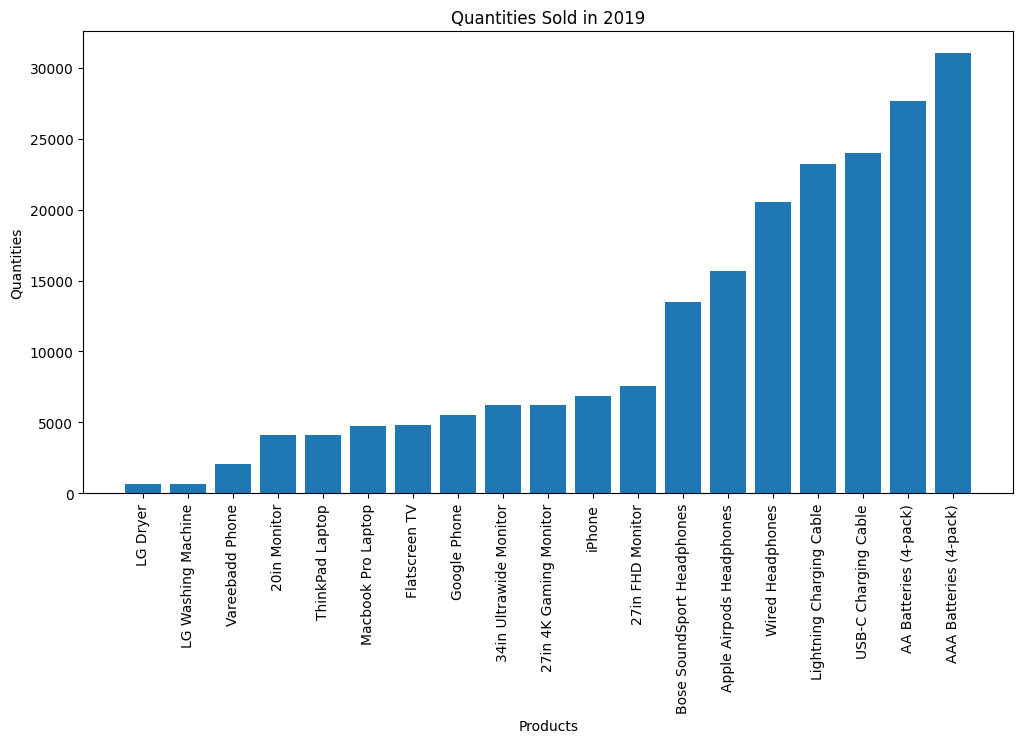

In [28]:
# Create a figure
fig= plt.subplots(figsize=(12, 6))

# Sort the data by "Quantity Ordered" in ascending order
Product_Quantities = Product_Quantities.sort_values(by="Quantity Ordered", ascending=True)

# Create a bar plot
plt.bar(Product_Quantities["Product"], Product_Quantities["Quantity Ordered"])

# Set plot title, labels, and customize tick rotation
plt.title("Quantities Sold in 2019")
plt.xlabel("Products")
plt.xticks(Product_Quantities["Product"], rotation='vertical')
plt.ylabel("Quantities")

# Display the plot
plt.show()

As we can see, products with a relatively low price are amongst the ones ordered the most (e.g. Batteries, Charging Cables, Headphones). Let us see if there is a correlation between price and quantities and let us create more vizualizations to see the relationship between the prices and the quantities.

In [29]:
# Calculate the sum of all Sales based on Months
Product_Price = df.groupby(['Product'])['Price Each'].mean()
Product_Price = pd.DataFrame(Product_Price)
Product_Price = Product_Price.reset_index()

Products = pd.merge(Product_Price, Product_Quantities, on=['Product'])
Products = Products.sort_values(by="Quantity Ordered",ascending=True)

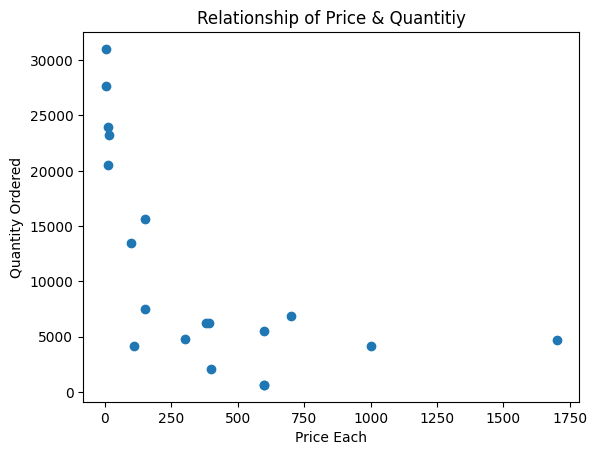

In [30]:
# Create a scatterplot
plt.scatter(Products['Price Each'], Products['Quantity Ordered'])

# Add labels and a title
plt.xlabel('Price Each')
plt.ylabel('Quantity Ordered')
plt.title('Relationship of Price & Quantitiy')

# Show the plot
plt.show()

In [31]:
#calculation correlation coefficient and p-value between x and y
pearsonr(Products['Price Each'], Products['Quantity Ordered'])

PearsonRResult(statistic=-0.601443055993455, pvalue=0.006449384736596729)

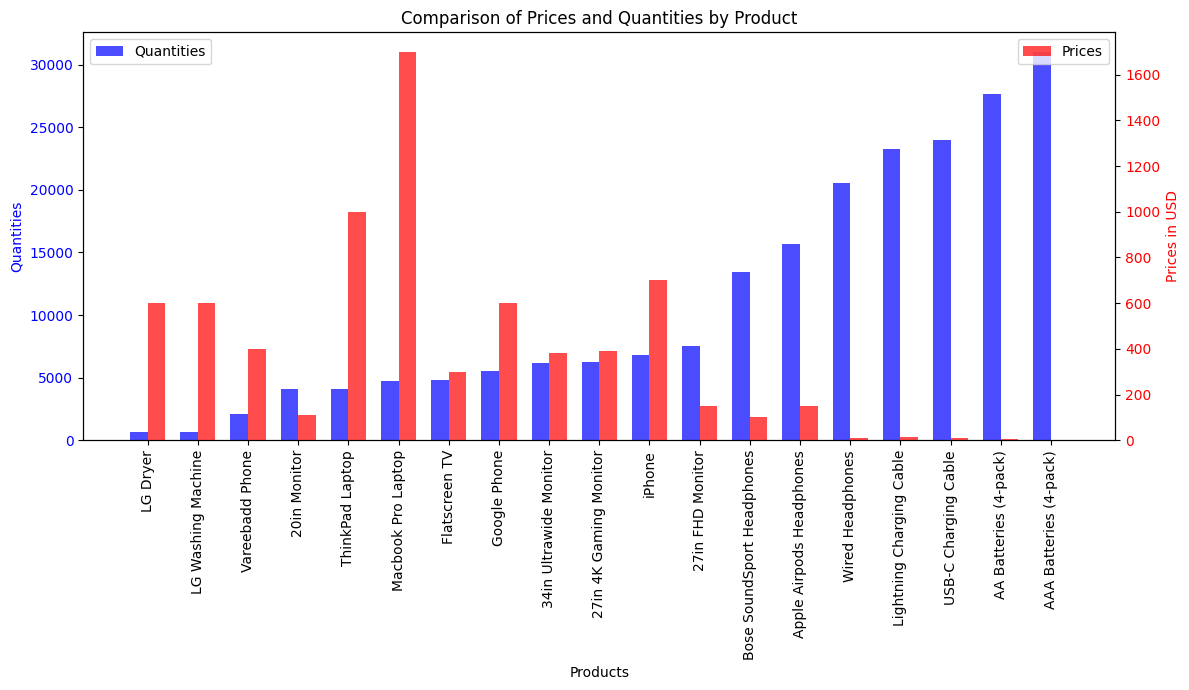

In [32]:
# Define the width of each bar group
bar_width = 0.35

# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(12, 7))

products = Products['Product']
quantities = Products['Quantity Ordered']
prices = Products['Price Each']

# Calculate the x positions for each group of bars
x_quantities = np.arange(len(products))
x_prices = [x + bar_width for x in x_quantities]

# Create the first set of bars for quantities
ax1.bar(x_quantities, quantities, width=bar_width, color='b', alpha=0.7, label='Quantities')
ax1.set_xlabel('Products')
ax1.set_ylabel('Quantities', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the second y-axis (twin y-axis)
ax2 = ax1.twinx()

# Create the second set of bars for prices
ax2.bar(x_prices, prices, width=bar_width, color='r', alpha=0.7, label='Prices')
ax2.set_ylabel('Prices in USD', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set x-axis ticks and labels for each group
x_ticks = [x + bar_width / 2 for x in x_quantities]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(products, rotation=90)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set a title
plt.title('Comparison of Prices and Quantities by Product')

# Show the plot
plt.tight_layout()  # Ensures labels and titles fit within the figure
plt.show()

#### Answer Question 5:
It appears to be that we especially sold many products that have a very low price. More pricey items such as Dryers, Laptops, Monitors and Phones are less freuqent orded as less expsenive ones. Also the pearson correlation test shows a significant negative correlation  (-0.6) of price and quantity. As price might be one reason why batteries, charging cables and headphones are ordered more frequently, there migth be also other reasons. Batteries, charging cables, and headphones are consumable items, meaning they have a limited lifespan, and customers need to replace them regularly. For example, batteries may need to be replaced when they run out of charge, charging cables can wear out or get lost, and headphones may break or wear down over time.
Furthermore, these products have versatile uses and are compatible with many devices. Charging cables, for instance, can be used with various electronic devices such as smartphones, tablets, and laptops. This versatility increases the likelihood of customers needing multiple cables. Finally customers may find it more convenient and cost-effective to replace inexpensive items like batteries, charging cables, and headphones rather than investing in costly repairs or replacements of the devices they connect to.